Sorting Harry Potter Charcters

## Load Dataset and Import Libraries

In [1]:
import os, zipfile
import re

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, classification_report
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = './dataset/Harry Potter'
data = []

for file_name in os.listdir(data_path):
    if file_name.endswith('.txt'):

        book_title = file_name[3:-4]
        file_path = os.path.join(data_path, file_name)

        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        
        data.append({'Book Title': book_title, 'Text': text})

df = pd.DataFrame(data, columns=['Book Title', 'Text'])

In [3]:
pd.options.display.max_columns = None
df.head(7)

,Book Title,Text
0,Harry Potter and the Sorcerers Stone,"M r. and Mrs. Dursley, of number four, Privet ..."
1,Harry Potter and the Chamber of Secrets,"Not for the first time, an argument had broken..."
2,Harry Potter and the Prisoner of Azkaban,Harry Potter was a highly unusual boy in many ...
3,Harry Potter and the Goblet of Fire,The villagers of Little Hangleton still called...
4,Harry Potter and the Order of the Phoenix,The hottest day of the summer so far was drawi...
5,Harry Potter and the Half-Blood Prince,It was nearing midnight and the Prime Minister...
6,Harry Potter and the Deathly Hallows,"The two men appeared out of nowhere, a few yar..."


## Feature Engineering

In [4]:
def remove_spaces(text):
    cleaned_text = text.strip()
    cleaned_text = ' '.join(cleaned_text.split())
    
    return cleaned_text

In [5]:
df['Text'] = df['Text'].apply(remove_spaces)

In [6]:
Houses = ['Gryffindor', 'Slytherin', 'Ravenclaw', 'Hufflepuff']

Houses_encoding_map = {'Gryffindor': 0, 'Slytherin': 1, 'Ravenclaw': 2, 'Hufflepuff': 3}

In [7]:
def extract_sentences(text, word):
    text = text
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)  # Split into sentences
    selected_sentences = [sentence for sentence in sentences if re.search(r'\b{}\b'.format(re.escape(word)), sentence)]
    return ' '.join(selected_sentences)


In [8]:
for house in Houses:
    df[f'{house} Sentences'] = df['Text'].apply(lambda text: extract_sentences(text, house))

In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser'])  # Disable parser for faster processing
nlp.max_length = 2000000

In [10]:
# def preprocess_text(text):
#     doc = nlp(text)
#     tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
#     cleaned_text = ' '.join(tokens)
    
#     return cleaned_text

In [11]:
# for house in Houses:
#     df[f'{house} Sentences'] = df[f'{house} Sentences'].apply(preprocess_text)

In [12]:
df.head(5)

,Book Title,Text,Gryffindor Sentences,Slytherin Sentences,Ravenclaw Sentences,Hufflepuff Sentences
0,Harry Potter and the Sorcerers Stone,"M r. and Mrs. Dursley, of number four, Privet ...","I’ve been asking around, and I hope I’m in Gry...","“Well, no one really knows until they get ther...","I’ve been asking around, and I hope I’m in Gry...","“Well, no one really knows until they get ther..."
1,Harry Potter and the Chamber of Secrets,"Not for the first time, an argument had broken...",Special permission from Dumbledore so he could...,"Every year, this aged old hat, patched, frayed...","Every year, this aged old hat, patched, frayed...","Every year, this aged old hat, patched, frayed..."
2,Harry Potter and the Prisoner of Azkaban,Harry Potter was a highly unusual boy in many ...,"Professor McGonagall, head of Gryffindor house...","Malfoy, who had a pale, pointed, sneering face...","‘Oh,’ said Hermione softly, ‘we’ve missed the ...","‘Oh,’ said Hermione softly, ‘we’ve missed the ..."
3,Harry Potter and the Goblet of Fire,The villagers of Little Hangleton still called...,"And Wales lost to Uganda, and Scotland was sla...",Then a long tear near the brim opened wide lik...,"Next they were hailed by Ernie Macmillan, a Hu...",He was Captain and Seeker of the Hufflepuff Ho...
4,Harry Potter and the Order of the Phoenix,The hottest day of the summer so far was drawi...,"'You know, maybe it wouldn't be a bad idea to ...",'Boy and girl from each.' 'And guess who's a S...,"Luna's in my year, but in Ravenclaw.' 'Wit bey...",Harrys eyes were screwed up against the rush o...


In [13]:
def extract_character_names(text):
    doc = nlp(text)
    character_names = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    
    return character_names

In [14]:
all_names = []

for house in Houses:
    for text in df[f'{house} Sentences']:
        character_names = extract_character_names(text)
        all_names.extend(character_names)

# Remove duplicates
all_names = list(set(all_names))
character_df = pd.DataFrame(all_names, columns=['Character'])

In [15]:
character_df.shape

(258, 1)

In [16]:
character_df.sample(10)

,Character
229,Salazar Slytherin
175,Nasty
222,Lisa
136,Hooch
96,Parvati Patil
107,Shrewd Slytherin
128,Peter
35,George Weasley
187,Derrick
60,Lockhart


In [17]:
character_df = character_df.assign(**{col: 0 for col in Houses})

In [18]:
def count_character_appearances(character_name):
    counts = []
    
    for house in Houses:
        repetitions = 0
        for word in character_name.split():
            repetitions += df[f'{house} Sentences'].str.count(word).sum()
        
        counts.append(repetitions)

    return counts


for character in character_df['Character']:
    counts = count_character_appearances(character)
    character_df.loc[character_df['Character'] == character, Houses] = counts
    

In [19]:
for index, row in character_df.select_dtypes('number').iterrows():
    max_house = row.idxmax()  # idxmax() returns the index of the first occurrence of the maximum value
    
    # Add the name of the column with the highest number to a new column 'House'
    character_df.at[index, 'House'] = max_house

In [20]:
character_df['House Encoded'] = character_df['House'].map(Houses_encoding_map)

In [21]:
character_df.sample(10)

,Character,Gryffindor,Slytherin,Ravenclaw,Hufflepuff,House,House Encoded
64,Miss Granger,12,1,2,1,Gryffindor,0
238,Bold Gryffindor,609,72,36,31,Gryffindor,0
230,Malfoy,28,42,3,1,Slytherin,1
224,Helga Hufflepuff,30,32,30,116,Hufflepuff,3
209,Voldemort,0,8,3,1,Slytherin,1
114,Trelawney,2,0,0,0,Gryffindor,0
142,Godric’s Hollow,8,0,0,0,Gryffindor,0
48,squashy armchairs,6,0,0,0,Gryffindor,0
90,Shh,1,0,0,0,Gryffindor,0
174,Fred and George,589,307,134,129,Gryffindor,0


## Utility Functions

In [22]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    print(f"Mean accuracy of train set: {model.score(X_train, y_train):4f}")

In [23]:
def test_model(model, x_test, y_test):
    y_pred = model.predict(x_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy: >.6}\n")

    # Calculate Precision, Recall, and F1 score
    print(classification_report(y_test, y_pred))

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=[8,3])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', cbar=False, linewidths=1,
                xticklabels=[f'Predicted {Houses[i]}' for i in range(4)],
                yticklabels=[f'Actual {Houses[i]}' for i in range(4)])

    plt.title('Confusion Matrix')

## Train and Evaluate Model

In [24]:
X_train = character_df.select_dtypes('number').drop('House Encoded', axis=1)
y_train = character_df['House Encoded']

In [25]:
random_forest_model = RandomForestClassifier(random_state=13)
train_model(random_forest_model, X_train, y_train)

Mean accuracy of train set: 1.000000


In [26]:
test_df = pd.read_csv("dataset/Harry Potter/Test.csv")
test_df.head(5)

,Character,Hogwarts House
0,Harry Potter,Gryffindor
1,Hermione Granger,Gryffindor
2,Ron Weasley,Gryffindor
3,Draco Malfoy,Slytherin
4,Luna Lovegood,Ravenclaw


In [30]:
for character in test_df['Character']:
    counts = count_character_appearances(character)
    test_df.loc[test_df['Character'] == character, Houses] = counts

test_df['Hogwarts House Encoded'] = test_df['Hogwarts House'].map(Houses_encoding_map)

test_df.sample(10)

,Character,Hogwarts House,Gryffindor,Slytherin,Ravenclaw,Hufflepuff,Hogwarts House Encoded
19,Narcissa Malfoy,Slytherin,28.0,42.0,3.0,1.0,1
7,Fred Weasley,Gryffindor,47.0,23.0,3.0,9.0,0
8,George Weasley,Gryffindor,50.0,26.0,4.0,10.0,0
49,Anthony Goldstein,Ravenclaw,0.0,0.0,4.0,2.0,2
38,Padma Patil,Ravenclaw,4.0,0.0,6.0,2.0,2
45,Vincent Crabbe,Slytherin,1.0,10.0,0.0,0.0,1
17,Bellatrix Lestrange,Slytherin,2.0,0.0,0.0,0.0,1
31,The Bloody Baron,Slytherin,126.0,76.0,27.0,22.0,1
29,Moaning Myrtle,Ravenclaw,0.0,1.0,0.0,0.0,2
34,Ernie Macmillan,Hufflepuff,2.0,3.0,4.0,18.0,3


In [28]:
X_test = test_df.select_dtypes('number').drop('Hogwarts House Encoded', axis=1)
y_test = test_df['Hogwarts House Encoded']

Accuracy: 0.8

              precision    recall  f1-score   support

           0       0.70      1.00      0.82        21
           1       0.89      0.73      0.80        11
           2       1.00      0.45      0.62        11
           3       1.00      0.86      0.92         7

    accuracy                           0.80        50
   macro avg       0.90      0.76      0.79        50
weighted avg       0.85      0.80      0.79        50



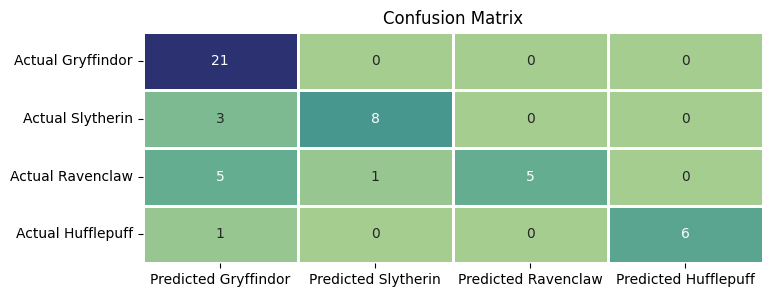

In [29]:
test_model(random_forest_model, X_test, y_test)